## Data cleaning

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None 

raw_data=pd.read_csv('https://data.cityofnewyork.us/resource/uip8-fykc.csv?$limit=200000')
new_data=raw_data.dropna(how='any')
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 154011 entries, 0 to 155506
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   arrest_key         154011 non-null  int64  
 1   arrest_date        154011 non-null  object 
 2   pd_cd              154011 non-null  float64
 3   pd_desc            154011 non-null  object 
 4   ky_cd              154011 non-null  float64
 5   ofns_desc          154011 non-null  object 
 6   law_code           154011 non-null  object 
 7   law_cat_cd         154011 non-null  object 
 8   arrest_boro        154011 non-null  object 
 9   arrest_precinct    154011 non-null  int64  
 10  jurisdiction_code  154011 non-null  int64  
 11  age_group          154011 non-null  object 
 12  perp_sex           154011 non-null  object 
 13  perp_race          154011 non-null  object 
 14  x_coord_cd         154011 non-null  int64  
 15  y_coord_cd         154011 non-null  int64  
 16  la

In [2]:
# convert arrest_boro to 'Bronx','Staten Island','Brooklyn','Manhattan','Queens'
new_data['arrest_boro'] = new_data['arrest_boro'].replace(['B','S','K','M','Q'],['Bronx','Staten_Island','Brooklyn','Manhattan','Queens'])
# replace space in new_data['pd_desc'] to "_"
new_data['pd_desc'] = new_data['pd_desc'].str.replace(" ","_")
new_data.head()

,arrest_key,arrest_date,pd_cd,pd_desc,ky_cd,ofns_desc,law_code,law_cat_cd,arrest_boro,arrest_precinct,jurisdiction_code,age_group,perp_sex,perp_race,x_coord_cd,y_coord_cd,latitude,longitude,geocoded_column
0,238013474,2021-12-18T00:00:00.000,157.0,RAPE_1,104.0,RAPE,PL 1303501,F,Queens,105,97,18-24,M,BLACK,1057636,203954,40.726187,-73.735234,POINT (-73.73523390399998 40.72618713000002)
1,236943583,2021-11-25T00:00:00.000,263.0,"ARSON_2,3,4",114.0,ARSON,PL 1501500,F,Brooklyn,69,71,25-44,M,BLACK,1014340,171320,40.636868,-73.891586,POINT (-73.89158591899997 40.63686750900007)
2,234938876,2021-10-14T00:00:00.000,594.0,OBSCENITY_1,116.0,SEX CRIMES,PL 2631100,F,Brooklyn,61,0,25-44,M,WHITE,995244,155739,40.594145,-73.960415,POINT (-73.96041495199995 40.59414516900005)
3,234788259,2021-10-11T00:00:00.000,263.0,"ARSON_2,3,4",114.0,ARSON,PL 1501001,F,Bronx,42,71,18-24,M,BLACK,1009058,239616,40.824340,-73.910365,POINT (-73.91036538099996 40.82433953100008)
5,234117071,2021-09-27T00:00:00.000,157.0,RAPE_1,104.0,RAPE,PL 1303501,F,Brooklyn,84,0,25-44,M,BLACK,989013,192652,40.695469,-73.982825,POINT (-73.98282507899995 40.69546894100006)


In [3]:
for feat in new_data.columns[:-1]:
    if new_data[feat].dtype == object:
        print(feat)

arrest_date
pd_desc
ofns_desc
law_code
law_cat_cd
arrest_boro
age_group
perp_sex
perp_race


In [4]:
len(new_data.ofns_desc.unique().tolist())

62

## Data exploratory analysis(maybe not)

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

## Database

In [6]:
import sqlite3
con = sqlite3.connect('nypd_data.db')
#new_data.to_sql(name='data_a',con=con)

## Dashboard

In [7]:
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display
from keplergl import KeplerGl
import requests
import numpy as np
from pandas.api.types import CategoricalDtype
import geopandas

In [16]:
ALL='ALL'
def unique_val(arr):
    unique=arr.unique().tolist()
    unique.sort()
    unique.insert(0,ALL)
    return unique

drop_boro=widgets.Dropdown(
    options= unique_val(new_data.arrest_boro),
    value=ALL,
    description='select boro'
)

def boro_date(change):
    #'Bronx','Staten Island','Brooklyn','Manhattan','Queens'
    if change==ALL:
        data=pd.read_sql("SELECT arrest_date, count(arrest_date) FROM data_a GROUP BY arrest_date",con=con)
    elif change=='Bronx':
        data=pd.read_sql("SELECT arrest_date, count(arrest_date) FROM data_a where arrest_boro=='Bronx' GROUP BY arrest_date",con=con)
    elif change=='Brooklyn':
        data=pd.read_sql("SELECT arrest_date, count(arrest_date) FROM data_a where arrest_boro=='Brooklyn' GROUP BY arrest_date",con=con)
    elif change=='Manhattan':
        data=pd.read_sql("SELECT arrest_date, count(arrest_date) FROM data_a where arrest_boro=='Manhattan' GROUP BY arrest_date",con=con)
    elif change=='Queens':
        data=pd.read_sql("SELECT arrest_date, count(arrest_date) FROM data_a where arrest_boro=='Queens' GROUP BY arrest_date",con=con)
    elif change=='Staten_Island':
        data=pd.read_sql("SELECT arrest_date, count(arrest_date) FROM data_a where arrest_boro=='Staten_Island' GROUP BY arrest_date",con=con)
    data['arrest_date'] = pd.to_datetime(data['arrest_date'],format='%Y/%m/%d')
    return data

def boro_ofns(change):
    if change==ALL:
        data=pd.read_sql("SELECT ofns_desc, count(ofns_desc) FROM data_a GROUP BY ofns_desc LIMIT 5",con=con)
    elif change=='Bronx':
        data=pd.read_sql("SELECT ofns_desc, count(ofns_desc) FROM data_a where arrest_boro=='Bronx' GROUP BY ofns_desc LIMIT 5",con=con)
    elif change=='Brooklyn':
        data=pd.read_sql("SELECT ofns_desc, count(ofns_desc) FROM data_a where arrest_boro=='Brooklyn' GROUP BY ofns_desc LIMIT 5",con=con)
    elif change=='Manhattan':
        data=pd.read_sql("SELECT ofns_desc, count(ofns_desc) FROM data_a where arrest_boro=='Manhattan' GROUP BY ofns_desc LIMIT 5",con=con)
    elif change=='Queens':
        data=pd.read_sql("SELECT ofns_desc, count(ofns_desc) FROM data_a where arrest_boro=='Queens' GROUP BY ofns_desc LIMIT 5",con=con)
    elif change=='Staten_Island':
        data=pd.read_sql("SELECT ofns_desc, count(ofns_desc) FROM data_a where arrest_boro=='Staten_Island' GROUP BY ofns_desc LIMIT 5",con=con)
    return data
    

def boro_sex(change):
    if change==ALL:
        data=pd.read_sql("SELECT perp_sex,age_group, count(age_group) FROM data_a GROUP BY perp_sex,age_group",con=con)
    elif change=='Bronx':
        data=pd.read_sql("SELECT perp_sex,age_group, count(age_group) FROM data_a where arrest_boro=='Bronx' GROUP BY perp_sex,age_group",con=con)
    elif change=='Brooklyn':
        data=pd.read_sql("SELECT perp_sex,age_group, count(age_group) FROM data_a where arrest_boro=='Brooklyn' GROUP BY perp_sex,age_group",con=con)
    elif change=='Manhattan':
        data=pd.read_sql("SELECT perp_sex,age_group, count(age_group) FROM data_a where arrest_boro=='Manhattan' GROUP BY perp_sex,age_group",con=con)
    elif change=='Queens':
        data=pd.read_sql("SELECT perp_sex,age_group, count(age_group) FROM data_a where arrest_boro=='Queens' GROUP BY perp_sex,age_group",con=con)
    elif change=='Staten_Island':
        data=pd.read_sql("SELECT perp_sex,age_group, count(age_group) FROM data_a where arrest_boro=='Staten_Island' GROUP BY perp_sex,age_group",con=con)
    cat_size_order = CategoricalDtype(
    ['<18','18-24','25-44','45-64','65+'], 
    ordered=True
    )
    data['age_group'] = data['age_group'].astype(cat_size_order)
    data.sort_values('age_group')
    return data

def boro_race(change):
    if change==ALL:
        data=pd.read_sql("SELECT perp_race,age_group, count(age_group) FROM data_a GROUP BY perp_race,age_group",con=con)
    elif change=='Bronx':
        data=pd.read_sql("SELECT perp_race,age_group, count(age_group) FROM data_a where arrest_boro=='Bronx' GROUP BY perp_race,age_group",con=con)
    elif change=='Brooklyn':
        data=pd.read_sql("SELECT perp_race,age_group, count(age_group) FROM data_a where arrest_boro=='Brooklyn' GROUP BY perp_race,age_group",con=con)
    elif change=='Manhattan':
        data=pd.read_sql("SELECT perp_race,age_group, count(age_group) FROM data_a where arrest_boro=='Manhattan' GROUP BY perp_race,age_group",con=con)
    elif change=='Queens':
        data=pd.read_sql("SELECT perp_race,age_group, count(age_group) FROM data_a where arrest_boro=='Queens' GROUP BY perp_race,age_group",con=con)
    elif change=='Staten_Island':
        data=pd.read_sql("SELECT perp_race,age_group, count(age_group) FROM data_a where arrest_boro=='Staten_Island' GROUP BY perp_race,age_group",con=con)
    
    cat_size_order = CategoricalDtype(
    ['<18','18-24','25-44','45-64','65+'], 
    ordered=True
    )
    data['age_group'] = data['age_group'].astype(cat_size_order)
    data.sort_values('age_group')
    return data

def boro_race_law(change):
    if change==ALL:
        data=pd.read_sql("SELECT law_cat_cd,perp_race, count(perp_race) FROM data_a GROUP BY law_cat_cd,perp_race",con=con)
    elif change=='Bronx':
        data=pd.read_sql("SELECT law_cat_cd,perp_race, count(perp_race) FROM data_a where arrest_boro=='Bronx' GROUP BY law_cat_cd,perp_race",con=con)
    elif change=='Brooklyn':
        data=pd.read_sql("SELECT law_cat_cd,perp_race, count(perp_race) FROM data_a where arrest_boro=='Brooklyn' GROUP BY law_cat_cd,perp_race",con=con)
    elif change=='Manhattan':
        data=pd.read_sql("SELECT law_cat_cd,perp_race, count(perp_race) FROM data_a where arrest_boro=='Manhattan' GROUP BY law_cat_cd,perp_race",con=con)
    elif change=='Queens':
        data=pd.read_sql("SELECT law_cat_cd,perp_race, count(perp_race) FROM data_a where arrest_boro=='Queens' GROUP BY law_cat_cd,perp_race",con=con)
    elif change=='Staten_Island':
        data=pd.read_sql("SELECT law_cat_cd,perp_race, count(perp_race) FROM data_a where arrest_boro=='Staten_Island' GROUP BY law_cat_cd,perp_race",con=con)
    
    return data

def boro_age_law(change):
    if change==ALL:
        data=pd.read_sql("SELECT law_cat_cd,age_group, count(age_group) FROM data_a GROUP BY law_cat_cd,age_group",con=con)
    elif change=='Bronx':
        data=pd.read_sql("SELECT law_cat_cd,age_group, count(age_group) FROM data_a where arrest_boro=='Bronx' GROUP BY law_cat_cd,age_group",con=con)
    elif change=='Brooklyn':
        data=pd.read_sql("SELECT law_cat_cd,age_group, count(age_group) FROM data_a where arrest_boro=='Brooklyn' GROUP BY law_cat_cd,age_group",con=con)
    elif change=='Manhattan':
        data=pd.read_sql("SELECT law_cat_cd,age_group, count(age_group) FROM data_a where arrest_boro=='Manhattan' GROUP BY law_cat_cd,age_group",con=con)
    elif change=='Queens':
        data=pd.read_sql("SELECT law_cat_cd,age_group, count(age_group) FROM data_a where arrest_boro=='Queens' GROUP BY law_cat_cd,age_group",con=con)
    elif change=='Staten_Island':
        data=pd.read_sql("SELECT law_cat_cd,age_group, count(age_group) FROM data_a where arrest_boro=='Staten_Island' GROUP BY law_cat_cd,age_group",con=con)
    
    cat_size_order = CategoricalDtype(
    ['<18','18-24','25-44','45-64','65+'], 
    ordered=True
    )
    data['age_group'] = data['age_group'].astype(cat_size_order)
    data.sort_values('age_group')
    
    return data

def boro_map(change,axbig,map):
    if change==ALL:
        map.plot("area", alpha=0.5, edgecolor='k',legend=False,ax=axbig)
        point=geopandas.GeoDataFrame(new_data.arrest_boro,
                                    geometry=geopandas.GeoSeries.from_wkt(new_data.geocoded_column))

    elif change=='Bronx':
        map[map.BoroCode==2].plot("area", alpha=0.5, edgecolor='k',legend=False,ax=axbig)
        point=geopandas.GeoDataFrame(new_data.arrest_boro[new_data.arrest_boro=='Bronx'],
                                    geometry=geopandas.GeoSeries.from_wkt(new_data.geocoded_column))
    elif change=='Brooklyn':
        map[map.BoroCode==3].plot("area", alpha=0.5, edgecolor='k',legend=False,ax=axbig)
        point=geopandas.GeoDataFrame(new_data.arrest_boro[new_data.arrest_boro=='Brooklyn'],
                                    geometry=geopandas.GeoSeries.from_wkt(new_data.geocoded_column))
    elif change=='Manhattan':
        map[map.BoroCode==1].plot("area", alpha=0.5, edgecolor='k',legend=False,ax=axbig)
        point=geopandas.GeoDataFrame(new_data.arrest_boro[new_data.arrest_boro=='Manhattan'],
                                    geometry=geopandas.GeoSeries.from_wkt(new_data.geocoded_column))
    elif change=='Queens':
        map[map.BoroCode==4].plot("area", alpha=0.5, edgecolor='k',legend=False,ax=axbig)
        point=geopandas.GeoDataFrame(new_data.arrest_boro[new_data.arrest_boro=='Queens'],
                                    geometry=geopandas.GeoSeries.from_wkt(new_data.geocoded_column))
    elif change=='Staten Island':
        map[map.BoroCode==5].plot("area", alpha=0.5, edgecolor='k',legend=False,ax=axbig)
        point=geopandas.GeoDataFrame(new_data.arrest_boro[new_data.arrest_boro=='Staten_Island'],
                                    geometry=geopandas.GeoSeries.from_wkt(new_data.geocoded_column))
    point.plot(ax=axbig,legend=False,alpha = 0.01)
    
    

def draw_box(change):
    fig, axes = plt.subplots(ncols=2, nrows=4,figsize=(16, 15),constrained_layout = True)
     

    #draw boro arrest time
    sns.lineplot(ax=axes[0][0],x='arrest_date',y='count(arrest_date)',data= boro_date(change))
    #draw boro ofns category
    piechart,texts=axes[0][1].pie(boro_ofns(change)['count(ofns_desc)'])
    ratio = 100.*boro_ofns(change)['count(ofns_desc)']/boro_ofns(change)['count(ofns_desc)'].sum()
    labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(boro_ofns(change)['ofns_desc'],ratio)]
    sort_legend = True
    if sort_legend:
        piechart, labels, dummy =  zip(*sorted(zip(piechart, labels,boro_ofns(change)['count(ofns_desc)']),
                                          key=lambda x: boro_ofns(change)['ofns_desc'][2],
                                          reverse=True))
    axes[0][1].legend(piechart, labels, loc='upper left', bbox_to_anchor=(0.95,1.025),fontsize=10)
    #

    sns.barplot(ax=axes[1][0],x='age_group',y="count(age_group)", hue="perp_sex",palette="pastel", data=boro_sex(change))

    #
    sns.barplot(ax=axes[1][1],x='age_group',y="count(age_group)", hue="perp_race",palette="pastel", data=boro_race(change))
    axes[1][1].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

    #

    sns.barplot(ax=axes[2][0],x="count(age_group)", y="age_group", hue="law_cat_cd",data=boro_age_law(change),palette="pastel")
    #
    sns.barplot(ax=axes[3][0],x="count(perp_race)", y="law_cat_cd",hue="perp_race",data=boro_race_law(change),palette="pastel")
    axes[2][1].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)




    
    grid_subplot = axes[2,0].get_gridspec()
    for ax in axes[-2:, -1]:
        ax.remove()
    axbig = fig.add_subplot(grid_subplot[-2:, -1])
    
    #    
    path_to_data = geopandas.datasets.get_path("nybb")
    nyc_map = geopandas.read_file(path_to_data)
    nyc_map=nyc_map.set_index("BoroName")
    nyc_map["area"]=nyc_map.area
    nyc_map =nyc_map.set_geometry("geometry")
    nyc_map_4326 = nyc_map.to_crs("EPSG:4326")
    boro_map(change,axbig,nyc_map_4326)
    
interact(draw_box,change=drop_boro)


interactive(children=(Dropdown(description='select boro', options=('ALL', 'Bronx', 'Brooklyn', 'Manhattan', 'Q…

<function __main__.draw_box(change)>

## Arrest Data Map Near Me

In [9]:
import ipywidgets as widgets #Package for python widgets
from ipyleaflet import Map,basemaps,Marker #Package enabling interactive maps in the Jupyter notebook
from IPython.display import display

In [10]:
# get my location
import requests
import json
def display_ip():
   ip_request = requests.get('https://get.geojs.io/v1/ip.json')
   my_ip = ip_request.json()['ip']
   geo_request = requests.get('https://get.geojs.io/v1/ip/geo/' +my_ip + '.json')
   geo_data = geo_request.json()
   return(geo_data['latitude'],geo_data['longitude'])
 
location = display_ip()
my_latitude = float(location[0])
my_longitude = float(location[1])

In [11]:
# location of NYU Stern Business School
my_latitude = 40.728515
my_longitude = -73.994781

In [12]:
#Initialize a 2*2 grid layout
# grid = widgets.GridspecLayout(2, 2, height='900px')

#Initialize a Map
center = [my_latitude, my_longitude]
zoom = 16.1
m = Map(basemap=basemaps.OpenStreetMap.Mapnik,center=center, zoom=zoom)

#Initialize an output widget 
# result_point = widgets.Output()

In [13]:
#Define the filtering function (from Karim's algorithm) 
def common_filtering(m):
    #clear the previous selection output on each iteration
#     result_point.clear_output()
    
    #clear the previous markers on the map
    base_layer = m.layers[0]
    m.clear_layers()
    m.add_layer(base_layer)
    
    #----------------------------------------ALGORITHM STARTS HERE----------------------------------------#
    #restaurant have multiple times they were test, keep only last grade
    results_df = new_data

    #calculate proximity: use absolute value delta of user's lat / long and the restaurant's; convert to miles where 1 degree = 68.703 miles
    results_df["distance"] = (abs(results_df['latitude'] - my_latitude) + abs(results_df['longitude'] - my_longitude)) * 68.703

    #sort by total distance column, smallest at the top
    results_df = results_df.sort_values(["distance"],ascending=[True])

    #get the nearest 50 results to display
    results_df = results_df.head(50)
    
    #----------------------------------------ALGORITHM ENDS HERE----------------------------------------#

    for index, row in results_df.iterrows():        
        center = (row['latitude'],row['longitude'])
        marker = Marker(location = center, draggable = False, title = str(row['arrest_key']))
        m.add_layer(marker)
        
    return(results_df)

In [14]:
#Filter the nearest point on map
result = common_filtering(m)
m

Map(center=[40.728515, -73.994781], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'…

<AxesSubplot:xlabel='age_group', ylabel='counts'>

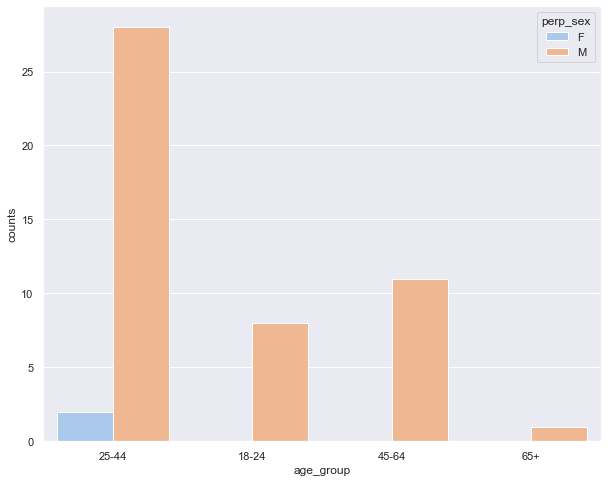

In [15]:
# statistic of the nearest 50 results
sns.set(rc={'figure.figsize':(10,8)})
sns.barplot(x='age_group',y="counts", hue="perp_sex",palette="pastel", data=result.groupby(['perp_sex','age_group']).size().reset_index(name='counts'))